In [1]:
# Imports
from astropy.visualization import make_lupton_rgb
import functools
import lsst.afw.image as afwImage
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.meas.base.measurementInvestigationLib as mil
import matplotlib.pyplot as plt
import modelling_research.dc2 as dc2
import modelling_research.meas_model as mrMeas
import lsst.meas.extensions.multiprofit.fit_multiband as mrTask
import modelling_research.tables as mrTables
import modelling_research.plot_matches as mrPlotMatches
import numpy as np
import matplotlib as mpl
import seaborn as sns

In [2]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

# Bands and colour balance
bands_weights = {'i': 1.0, 'r': 1.191, 'g': 2.249}

# Reference band for when we need to pick one
band_ref = 'r'
band_fit = 'griz'

In [3]:
# Construct Source Measurements from a cat
def get_source_meas_all(bbox, cat, column_mag, mag_min, wcs, column_ra=None, column_dec=None, zeropoint=None):
    if column_ra is None:
        column_ra = 'coord_ra'
    if column_dec is None:
        column_dec = 'coord_dec'
    bbox_begin = bbox.getBegin()
    (ra_c2, dec_c1), (ra_c1, dec_c2) = (
        wcs.pixelToSky(geom.Point2D(x))
        for x in (bbox_begin, bbox.getEnd())
    )
    ra_t, dec_t = cat[column_ra], cat[column_dec]
    mag = cat[column_mag]
    if zeropoint is not None:
        mag = -2.5*np.log10(mag) + zeropoint
    sources_within = np.where((ra_t > ra_c1) & (ra_t < ra_c2) & (dec_t > dec_c1) & (dec_t < dec_c2) & (mag < mag_min))[0]
    sources_input = []
    for idx in sources_within:
        cx, cy = wcs.skyToPixel(geom.SpherePoint(ra_t[idx], dec_t[idx], geom.radians)) - bbox_begin
        source = mrMeas.Source(
            idx_row=idx,
            measurements=[
                mrMeas.Measurement(
                    mag=mag[idx], ellipse=mrMeas.Ellipse(centroid=mrMeas.Centroid(x=cx, y=cy), shape=None),
                )
            ]
        )
        sources_input.append(source)
    return sources_input

In [4]:
# Load the original and Scarlet DC2 repo
name_scarlet = 'Scarlet'
name = name_scarlet
butler = Butler('/repo/dc2')
collection_prefix = 'u/dtaranu/DM-30734/w_2021_24/'
has_multiprofit = True

In [5]:
# Read the central patch (DC2 is 7x7 vs HSC's 9x9 patches)
dataId = dict(tract=3828, skymap='DC2')
catexps_calibs = {}
exps_orig = {}
cat_refs = {}
wcs_refs = {}
catexps = {}
catexps_b = {}
exps_orig_b = {}
calibs_p = {}
patch_main = 24
collections = collection_prefix

for patch in (patch_main,) if has_multiprofit else range(49):
    print(f'Reading patch {patch}')
    calibs_b = {}
    catexps_b = {}
    dataId['patch'] = patch
    is_main = patch == patch_main
    if is_main:
        cat_refs[name] = butler.get(
            'deepCoadd_ref', **dataId,
            collections=f'{collection_prefix}mpf_{band_ref}' if has_multiprofit else collection_prefix
        )
    for band in bands_weights:
        if has_multiprofit:
            collections = f'{collection_prefix}mpf_{band}'
        cat = butler.get('deepCoadd_meas', **dataId, band=band, collections=collections)
        exp = butler.get('deepCoadd_calexp', **dataId, band=band, collections=collections)
        if is_main:
            exp.variance.array = 1./np.sqrt(exp.variance.array)
            exp_main = exp
        catexps_b[band] = mrMeas.CatExp(band=band,
                                        cat=cat,
                                        img=exp.image if is_main else None,
                                        siginv=exp.variance if is_main else None,
                                        model=None)
        calibs_b[band] = exp.getPhotoCalib()
        # We don't need to keep these for the old deblender
        if is_main and (name == name_scarlet):
            exps_orig_b[band] = exp
        if band == band_ref:
            wcs_refs[name] = exp.getWcs()
    catexps_calibs[patch] = (catexps_b, calibs_b)
patch = patch_main
catexps[name], calibs = catexps_calibs[patch]
exps_orig[name] = exps_orig_b

Reading patch 24


In [6]:
# Load MultiProFit fits (if they exist, or calibrate cats otherwise)
band_ref = 'r'
name_nr = 'NR'
if has_multiprofit:
    # These structures are somewhat convoluted, sorry. Bear with it.
    reruns_mpf = {
        name_scarlet: [
            (name_nr, '/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/'),
        ]
    }
    namepaths = {}
    for name_deblender, reruns_d in reruns_mpf.items():
        for name_rerun, path_rerun in reruns_d:
            namepaths[f'{name_deblender}_{name_rerun}'] = (name_deblender, path_rerun)

    cats_mpf = {
        name_mpf: mrTables.read_split_cat_fits(f'{namepath[1]}{band_fit}/mpf_dc2_griz_3828_{patch}_mag.fits')
        for name_mpf, namepath in namepaths.items()
    }
else:
    cats_calib = {}
    for p, (catexps_b, calibs_b) in catexps_calibs.items():
        cats_calib_b = {}
        for band, catexp in catexps_b.items():
            cats_calib_b[band] = calibs_b[band].calibrateCatalog(catexp.cat)
        cats_calib[p] = cats_calib_b
    cats_mpf = {f'{name_scarlet}_{name_nr}': cats_calib[patch][band_ref]}

In [7]:
# Define measurements (models)
models_meas = {
    'Base PSF': mrMeas.Model('Base PSF', 'base_PsfFlux', 0),
    'CModel': mrMeas.Model('Stack CModel', 'modelfit_CModel', 2),
}
if has_multiprofit:
    models_meas['MPF Sersic']: mrMeas.Model('MPF Sersic', 'multiprofit_mg8serbpx', 1)
models_meas = {f'{name_scarlet}_{name_nr}': models_meas}

In [8]:
# Match against DC2
butler_ref = dc2.get_refcat(make=False)
if has_multiprofit:
    filters_single = ('g', 'r', 'i', 'z')
    filters_multi = ('griz',)
    band_multi = filters_multi[0]
    band_ref = 'r'
    get_path_cats = functools.partial(dc2.get_path_cats, patches_regex=patch_main)
else:
    filters_single = ('g', 'r', 'i')
    def get_path_cats(prefix, band, tract):
        return [(p, cats_calib_b[band]) for p, cats_calib_b in cats_calib.items()]

    def func_patch(patch):
        return patch

kwargs_get = {'skymap': 'DC2', 'collections': f'{collection_prefix}mpf_{band_multi}' if has_multiprofit else collection_prefix}

if has_multiprofit:
    cats_dc2 = {
        name: dc2.match_refcat_dc2(
            butler_ref, match_afw=False,
            tracts={3828: (path, '2.2i'),}, butlers_dc2={'2.2i': butler},
            filters_single=filters_single, filters_multi=filters_multi, func_path=get_path_cats,
            kwargs_get={'skymap': 'DC2', 'collections': collections},
        )
        for name, (name_butler, path) in namepaths.items()
    }
else:
    cats_dc2 = {
        f'{name_scarlet}_{name_nr}': dc2.match_refcat_dc2(
            butler_ref, match_afw=False,
            tracts={3828: (None, '2.2i'),}, butlers_dc2={'2.2i': butler},
            filters_single=filters_single, filters_multi=(),
            func_path=get_path_cats, func_patch=func_patch,
            kwargs_get=kwargs_get,
        )
    }

/home/dtaranu/src/mine/modelling_research/dc2.py:60: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(refcat_path)
/home/dtaranu/src/mine/modelling_research/dc2.py:60: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(refcat_path)


Loading tract 3828 band r
Loading 1 files from path=/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/r/mpf_dc2_r_3828_24_mag.fits
Loaded in 20.5s; loading 24 (1/1) and matching file=/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/r/mpf_dc2_r_3828_24_mag.fits; len(cat,truth)=17093,103108
Loading tract 3828 band g
Loading 1 files from path=/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/g/mpf_dc2_g_3828_24_mag.fits
Loaded in 3.2s; loading 24 (1/1) file=/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/g/mpf_dc2_g_3828_24_mag.fits; len(cat,truth)=17093,103108
Loading tract 3828 band i
Loading 1 files from path=/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/i/mpf_dc2_i_3828_24_mag.fits
Loaded in 3.1s; loading 24 (1/1) file=/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/i/mpf_dc2_i_3828_24_mag.fits; len(cat,truth)=17093,103108
Loading tract 3828 band z
Loading 1 files from path=/project/dtaranu/dc2_gen3/w_2021_24_multibandfit/calcats/z/mp

In [9]:
# Plot matches
plot_matches = False
if plot_matches:
    args = dict(scatterleft=True, scatterright=True, densityplot=sns.histplot, cmap='Reds')
    args_types = {
        True: {
            'limx': (14.5, 24.5),
            'limy': (-0.5, 0.5),
        },
        False: {
            'limx': (16, 23),
            'limy': (-0.08, 0.08),
        },
    }
    for resolved, args_type in args_types.items():
        mrPlotMatches.plot_matches(
            cats_dc2[f'{name_scarlet}_{name_nr}'], resolved, models_meas[f'{name_scarlet}_{name_nr}'],
            filters_single, band_ref=band_ref, band_multi=None,
            band_ref_multi=band_ref, mag_max=24.5, match_dist_asec=0.168,
            plot_compure=False, rematch=True, **args_type, **args
        )

In [10]:
# Turn the grid off so it doesn't show up in images
sns.set_style('dark', {'axes.grid' : False, "xtick.color": 'k', "ytick.color": 'k'})

In [11]:
# Settings for DC2 sources in footprints
mag_min = 26
column_mag_true = f'lsst_{band_ref}_flux'
tract = 3828

In [12]:
# Find big stars
cat_meas = cats_mpf[f'{name_scarlet}_{name_nr}']
sizes = 0.2*np.sqrt(0.5*(cat_meas['modelfit_CModel_ellipse_xx'] + cat_meas['modelfit_CModel_ellipse_yy']))
mags = cat_meas['modelfit_CModel_mag']
big_stars = (mags > 16.25) & (mags < 17) & (sizes > 0.05) & (sizes < 0.3)
big_stars_rows = np.where(big_stars & (cat_meas['deblend_parentNChild'] > 0) & (cat_meas['deblend_parentNChild'] <= 8))[0]

idxs_parent = [
    int(np.where(cat_refs[name_scarlet]['id'] == cat_meas[int(x)]['parent'])[0][0])
    for x in big_stars_rows
]
if len(idxs_parent) > 10:
    idxs_parent = idxs_parent[:10]
print(idxs_parent)

plot_big_stars = False
if plot_big_stars:
    plt.scatter(mags, np.log10(sizes), s=0.5)
    plt.xlim(15, 32)
    plt.show()

[2274, 2375, 2786, 7270, 7289, 7314]


In [13]:
# These were identified earlier but should be similar to those found above
idxs_parent = [2274, 2375, 2786, 7270, 7289, 7314]

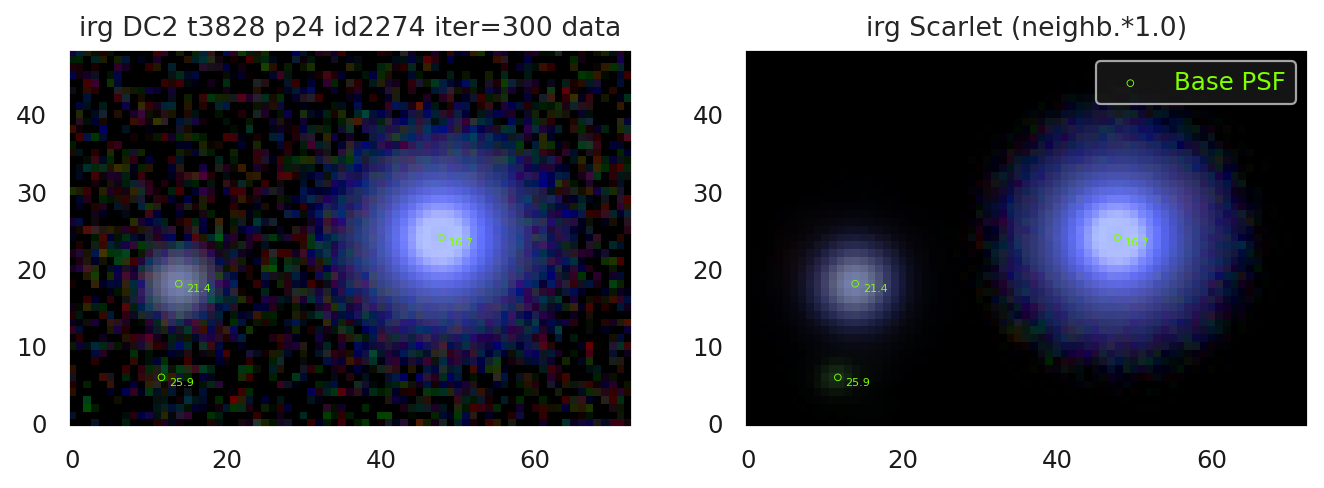

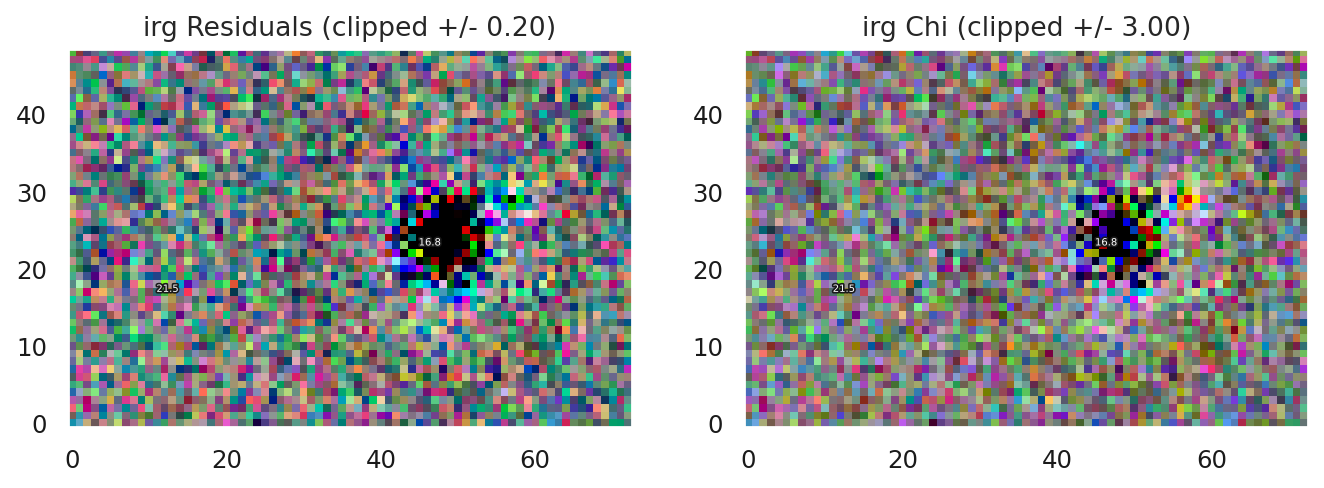

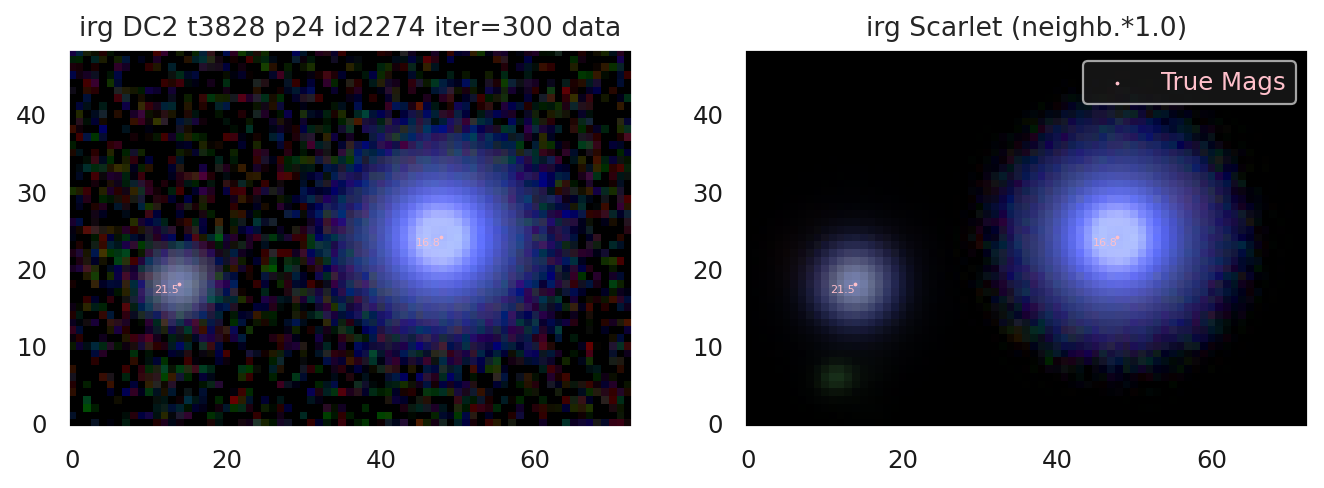

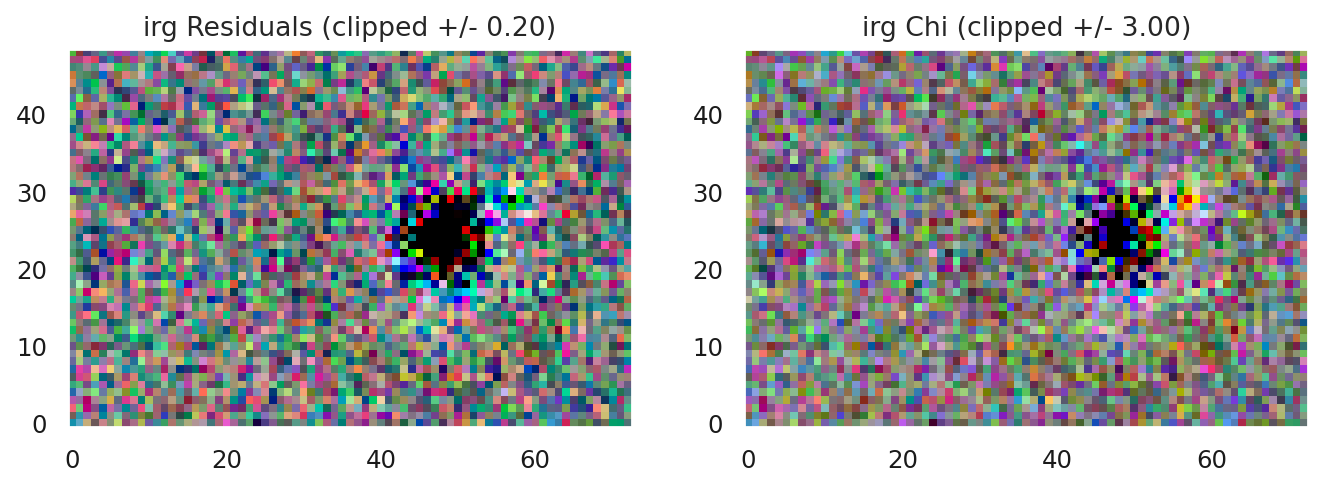

In [14]:
# Load a particular blend that has badly-behaved children (ha ha)
# Luckily all cats have the same parent, but that shouldn't be relied on
namepaths = {f'{name_scarlet}_{name_nr}': (name_scarlet, None)}
for idx_parent in idxs_parent[:1]:
    blend = mrMeas.Blend([
        mrMeas.Deblend(cat_ref=cat_refs[name], data=catexps_n, idx_parent=idx_parent, name_deblender=name)
        for name, catexps_n in catexps.items()
    ])

    sources_meas = {
        name_mpf: mrMeas.get_sources_meas(
            cats_mpf[name_mpf], blend.data[name_deblender].cat_ref, band_ref,
            blend.data[name_deblender].idx_children, models_meas[name_mpf],
        )
        for name_mpf, (name_deblender, *_) in namepaths.items()
    }
    
    # Plot up the parent blend
    reruns_plot = ((name_scarlet, name_nr),)
    bbox_xb, bbox_yb = blend.bbox.getBegin()
    offset = (-bbox_xb, -bbox_yb)
    measmodels = {
        name_scarlet: {'offset': offset, 'scatter_opts': dict(s=4, color='cyan', marker='+', linewidth=0.4)},
        'Base PSF': {'offset': offset, 'scatter_opts': dict(s=9, edgecolors='chartreuse', facecolors="None", marker='o', linewidth=0.4)},
    }
    truth = cats_dc2[f'{name_scarlet}_{name_nr}'][tract]['truth']
    sources_true = get_source_meas_all(
        bbox=blend.bbox, cat=truth, wcs=wcs_refs[name_scarlet],
        column_mag=column_mag_true, mag_min=mag_min, zeropoint=31.4,
    )
    for name_deblender, name_rerun in reruns_plot:
        deblend = blend.data[name_deblender]
        meas = sources_meas[f'{name_deblender}_{name_rerun}']
        is_scarlet = name_deblender == name_scarlet
        for do_sources_true in ((False, True) if is_scarlet else (True,)):
            measmodels_plot = {name_scarlet: measmodels[name_scarlet]} if is_scarlet and do_sources_true else measmodels
            fig, ax, fig_sig, ax_sig = deblend.plot(
                bands_weights, plot_sig=True, sources=meas,
                sources_true=sources_true if do_sources_true else None,
                sources_sig=sources_true if not do_sources_true else None,
                measmodels=measmodels_plot,
                label_data=f'DC2 t{tract} p{patch} id{idx_parent} iter={cat_meas[idx_parent]["deblend_iterations"]}',
                stretch=1, Q=12, residual_scale=0.2,
                show=False,
            )

Measurement(mag=16.690560530369027, ellipse=Ellipse(centroid=Centroid(x=13462.800720162917, y=13095.034723892966), shape=None))
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'cat_ref', 'children', 'data', 'idx_children', 'idx_parent', 'is_child', 'name_deblender', 'parent', 'plot']
(13435, 13067)


NameError: name 'blah' is not defined

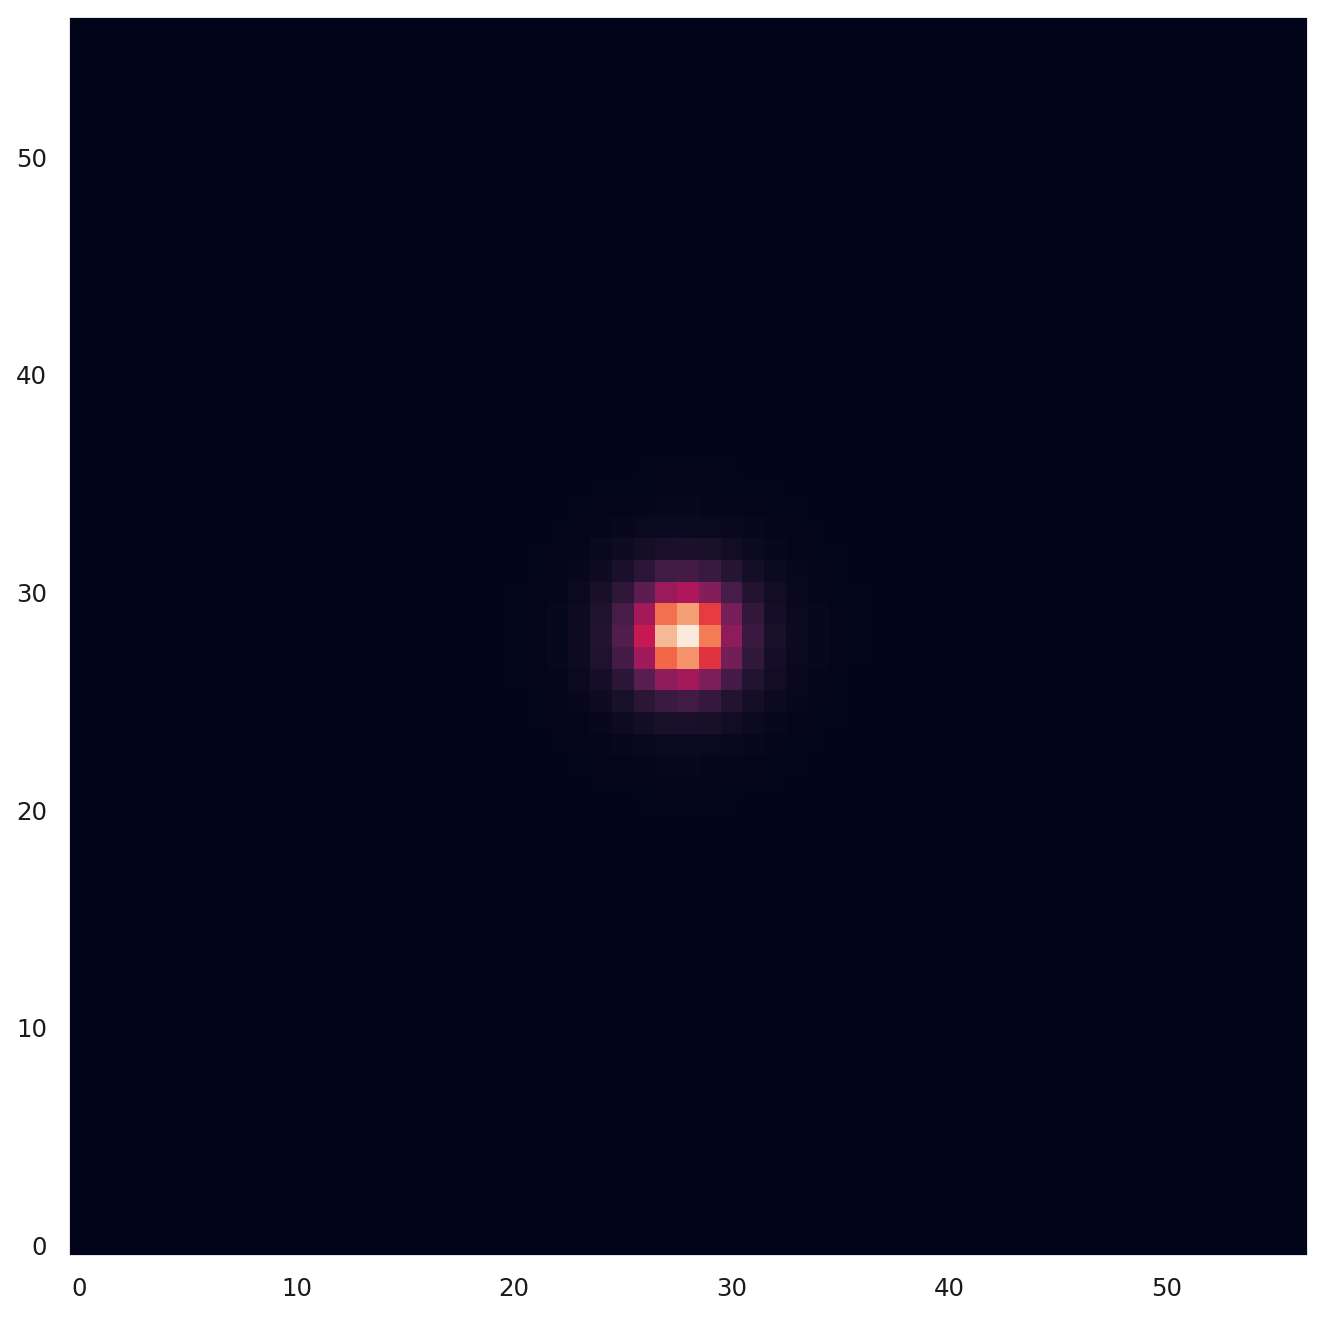

In [15]:
# Test PSF point making
from lsst.geom import Point2D
meas_psf = meas[0].measurements['Base PSF']
print(meas_psf)
print(dir(deblend))
img_psf = exp_main.getPsf().computeImage(Point2D(x=meas_psf.ellipse.centroid.x, y=meas_psf.ellipse.centroid.y))
print(img_psf.getXY0())
plt.imshow(img_psf.array)

print(blah)

In [17]:
#
print(meas_psf)
print(blend.bbox)

Measurement(mag=16.690560530369027, ellipse=Ellipse(centroid=Centroid(x=13462.800720162917, y=13095.034723892966), shape=None))
(minimum=(13415, 13071), maximum=(13487, 13119))


In [ ]:
# Find a misbehaving child
name_model = 'Base PSF'
for name_deblender, name_rerun in reruns_plot:
    deblend = blend.data[name_deblender]
    meas = sources_meas[f'{name_deblender}_{name_rerun}']
    bbox_parent = deblend.parent.getFootprint().getBBox()
    for idx_target, src in enumerate(meas):
        x, y = (x-y for x, y in zip(src.measurements[name_model].ellipse.centroid, bbox_parent.getBegin()))
        if 75 < x < 85 and 150 < y < 160:
            break
    print(f'{name_deblender} Found:', idx_target, x, y)
    target = deblend.children[idx_target]
    bbox_child = target.getFootprint().getBBox()
    bbox_offset = bbox_child.getBegin() - bbox_parent.getBegin()
    child_width, child_height = bbox_child.getWidth(), bbox_child.getHeight()
    bbox_xb, bbox_yb = bbox_child.getBegin()
    offset = (-bbox_xb, -bbox_yb)
    measmodels_deblend = {
        'Scarlet': {'offset': offset, 'scatter_opts': dict(s=16, edgecolors='aqua', facecolors='aqua', marker='+', linewidth=1)},
        'Base PSF': {'offset': offset, 'scatter_opts': dict(s=25, edgecolors='chartreuse', facecolors='None', marker='o', linewidth=0.8)},
    }
    measmodels_fit = {
        'MPF Sersic': {'offset': offset, 'scatter_opts': dict(s=16, edgecolors='aqua', facecolors='aqua', marker='+', linewidth=1)},
    }
    sources_true_child = get_source_meas_all(
        bbox=bbox_child, cat=truth, wcs=wcs_refs[name_scarlet],
        column_mag=column_mag_true, mag_min=mag_min, zeropoint=31.4
    )
    for measmodels_child, plot_sig in ((measmodels_deblend, False), (measmodels_fit, True)):
        _ = deblend.plot(
            bands_weights, bbox=bbox_child, plot_sig=plot_sig, sources=meas,
            sources_true=None,
            sources_sig=sources_true_child,
            measmodels=measmodels_child, label_data='DC2', stretch=1, Q=12, residual_scale=0.2,
        )

In [ ]:
# Plot child data with nearby models subtracted, and residuals relative to zero (i.e. vs sky noise only)
idx_children_sub = [
    idx for idx, child_d in enumerate(deblend.children)
    if idx != idx_target and child_d.getFootprint().getBBox().overlaps(bbox_child)
]
deblend = blend.data[name_scarlet]
_ = deblend.plot(
    bands_weights, plot_sig=True, bbox=bbox_child,
    sources=sources_meas[f'{name_scarlet}_{name_nr}'],
    sources_true=sources_true_child,
    #sources_sig=sources_true,
    idx_children_sub=idx_children_sub,
    measmodels=measmodels_child, label_data='DC2', stretch=1, Q=12, residual_scale=0.5, data_residual_factor=0,
)

In [ ]:
# Now let's do it the old noiseReplacer way
id_child = deblend.children[idx_target]['id']
for band, catexp in catexps['Scarlet'].items():
    noiseReplacer = mil.rebuildNoiseReplacer(exps_orig['Scarlet'][band], catexp.cat)
    noiseReplacer.insertSource(id_child)
_ = deblend.plot(
    bands_weights, plot_sig=True, bbox=bbox_child,
    sources=sources_meas[f'{name_scarlet}_NR'],
    sources_true=sources_true_child,
    #sources_sig=sources_true,
    idx_children_sub=idx_children_sub,
    measmodels=measmodels_child, label_data='DC2', stretch=1, Q=12, residual_scale=0.5, data_residual_factor=0,
)